# Getting started

`Sbijax` is a Python paclage for neural simulation-based inference and approximate Bayesian computation. Here we demonstrate its core functionality using a simple Gaussian model.

Interactive online version of this notebook:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dirmeier/sbijax/blob/main/docs/notebooks/introduction.ipynb)

In [1]:
import jax
import sbijax
%matplotlib inline
import matplotlib.pyplot as plt

## Model definition

To do approximate inference using `sbijax`, a user first has to define a prior model and a simulator function which can be used to generate synthetic data. We will be using a simple bivariate Gaussian as an example with the following generative model:

\begin{align}
\mu &\sim \mathcal{N}_2(0, I)\\
\sigma &\sim \mathcal{N}^+(1)\\
y & \sim \mathcal{N}_2(\mu, \sigma^2 I)
\end{align}

Using TensorFlow Probability, the prior model and simulator are implemented like this:

In [2]:
from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd

def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        mean=tfd.Normal(jnp.zeros(2), 1.0),
        scale=tfd.HalfNormal(jnp.ones(1)),
    ), batch_ndims=0)
    return prior


def simulator_fn(seed: jr.PRNGKey, theta: dict[str, jax.Array]):
    p = tfd.Normal(jnp.zeros_like(theta["mean"]), 1.0)
    y = theta["mean"] + theta["scale"] * p.sample(seed=seed)
    return y

## Inferential method definition

Having defined a model of interest, i.e., the prior and simulator functions, we construct an inferential method. Here, we use flow matching posterior estimation (FMPE) which is an algorithm that directly aims to learn an approximation to the posterior distribution (without intermediate steps like neural likelihood or neural likelihood-ratio estimation methods).

FMPE requires a continuous normalizing flow as a neural network model. We can construct it using the functionality provided by `sbijax`.

In [3]:
from sbijax.nn import make_cnf

n_dim_theta = 3
n_layers, hidden_size = 2, 128
neural_network = make_cnf(n_dim_theta, n_layers, hidden_size)

The neural network model in FMPE targets the posterior distribution and hence needs to target a space with its dimensionaliy. One can either find the dimensionality by inspecting the prior model (above, two for the mean and one for the scale), or use one of JAX internal methods, ravel_pytree, for this:

In [4]:
prior_draw = prior_fn().sample(seed=jr.PRNGKey(1))
prior_draw

{'scale': Array([1.2827358], dtype=float32),
 'mean': Array([ 1.1849145e+00, -8.9487137e-04], dtype=float32)}

In [5]:
len(jax.flatten_util.ravel_pytree(prior_draw)[0])

3

We can then construct the method itself. It takes as arguments a tuple of prior and simulator functions and the neural network.

In [6]:
from sbijax import FMPE

fns = prior_fn, simulator_fn
model = FMPE(fns, neural_network)

## Training and inference

Inference is then as easy as simulating some data, fitting the data to the model, a sampling from the approximate posterior. The data set is a dictionary of dictionaries (a PyTree in JAX lingo). It contains samples for the simulator function, called `y`, and parameter samples from the prior model, called `theta`.

In [7]:
data, _ = model.simulate_data(
    jr.PRNGKey(1),
    n_simulations=10_000,
)
data

{'y': Array([[ 0.11857828, -0.67052513],
        [ 0.8591581 ,  0.32408738],
        [ 0.15614688, -0.16291887],
        ...,
        [-0.7665508 ,  0.961631  ],
        [ 0.564456  , -0.17578089],
        [ 1.1174585 ,  0.62426066]], dtype=float32),
 'theta': {'scale': Array([[0.7736873 ],
         [0.25002995],
         [0.5289934 ],
         ...,
         [1.2977095 ],
         [0.60287726],
         [0.33322072]], dtype=float32),
  'mean': Array([[-0.20255503, -0.60199803],
         [ 0.5768567 ,  0.15704815],
         [-0.2408345 ,  0.03916928],
         ...,
         [-0.34609675, -0.84958166],
         [ 1.120803  ,  0.43456906],
         [ 1.4217944 ,  0.31761035]], dtype=float32)}}

We then fit the model using the typical flow matching loss. 

In [8]:
params, losses = model.fit(jr.PRNGKey(2), data=data)

  4%|██████████████▏                                                                                                                                                                                                                                                                                                                    | 44/1000 [00:17<06:27,  2.46it/s]


Finally, we sample from the posterior distribution for a specific observation $y_{\text{obs}}$.

In [9]:
y_obs = jnp.array([-1.0, 1.0])
inference_results, diagnostics = model.sample_posterior(
    jr.PRNGKey(3), params, y_obs, n_samples=1_000
)
print(inference_results)

Inference data with groups:
	> posterior
	> observed_data


## Visualization

`Sbijax` provides basic functionality to analyse posterior draws. We show some visualizations below.

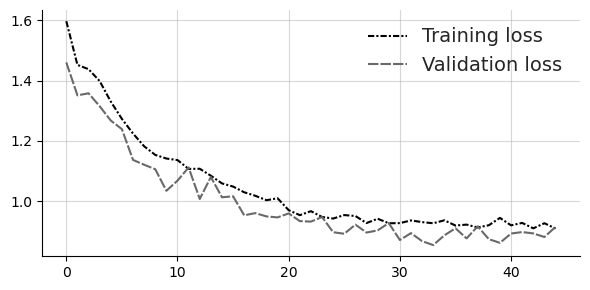

In [10]:
_, axes = plt.subplots(figsize=(6, 3))
sbijax.plot_loss_profile(losses, axes)
plt.show()

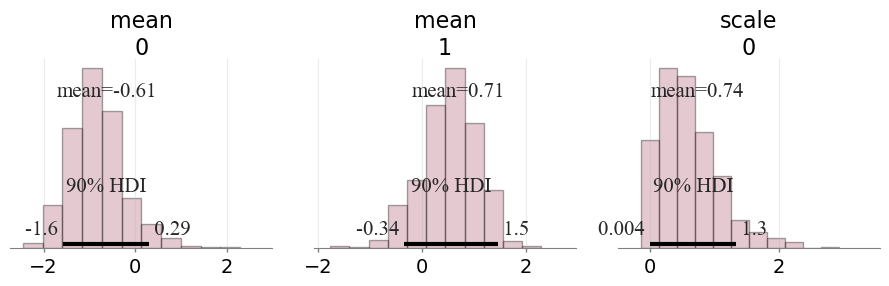

In [11]:
_, axes = plt.subplots(figsize=(9, 3), ncols=3)
sbijax.plot_posterior(inference_results, axes)
plt.show()

## Session info

In [12]:
import session_info

session_info.show(html=False)

-----
arviz                       0.17.1
haiku                       0.0.11
jax                         0.4.24
jaxlib                      0.4.24
matplotlib                  3.6.2
sbijax                      1.0.0
session_info                1.0.0
tensorflow_probability      0.24.0-dev20240224
-----
IPython             8.8.0
jupyter_client      7.4.9
jupyter_core        5.1.3
jupyterlab          3.5.2
notebook            6.5.2
-----
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) [Clang 14.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-07-18 16:12
